In [1]:
import os
import string
import cufflinks as cf

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

In [2]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Exploration

## Import Data


In [3]:
def get_data(file='', title_text=True, subject=False, date=False, nb_samples=5_000):

#     path = os.path.dirname(os.path.dirname(__file__)) + 'raw_data/'
#     data = pd.read_csv(path + file)
    
    data = pd.read_csv('../raw_data/fake_real_data.csv', nrows=nb_samples)

    features = ["article"]

    data[["article"]] = data["title"] + ' ' + data["text"]

    if date:
        data[["date"]] = pd.to_datetime(data["date"])
        features.append("date")

    if subject:
        features.append("subject")

    X = data[features]
    y = data["target"]

    return X, y

In [4]:
X, y = get_data()

## Clean Data

In [5]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

def lower(text):
    text = text.lower()
    return text

def number(text):
    text = ''.join(word for word in text if not word.isdigit())
    return text

def stop(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    text = [w for w in word_tokens if not w in stop_words]
    return text

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in text]
    text = lemmatized
    return text

def virg(text):
    text=" ".join(text)
    return text

In [6]:
X.article = X.article.apply(lower)
X.article = X.article.apply(number)
X.article = X.article.apply(stop)
X.article = X.article.apply(lemmatize)
X.article = X.article.apply(virg)

In [7]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## Count N_Grams

In [8]:
common_words = get_top_n_words(X.article, 20)
tmp = pd.DataFrame(common_words,columns=['word','count'])
tmp.groupby('word').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 UNIgrams used in articles',color='blue')
del tmp

In [9]:
common_words = get_top_n_bigram(X.article, 20)
tmp = pd.DataFrame(common_words, columns = ['words' ,'count'])
tmp.groupby('words').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 BIgrams used in articles', color='blue')
del tmp

In [10]:
common_words = get_top_n_trigram(X.article, 20)
tmp = pd.DataFrame(common_words, columns = ['words' ,'count'])
tmp.groupby('words').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 TRIgrams used in articles', color='blue')
del tmp

## WordCloud

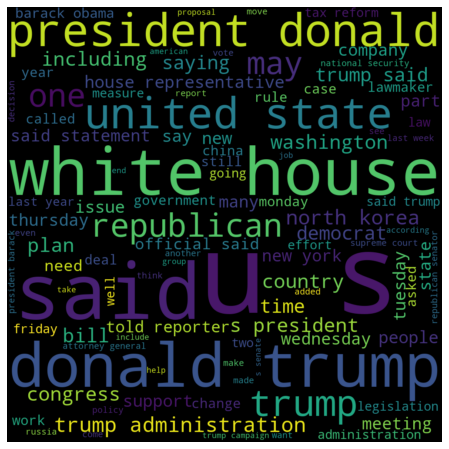

In [11]:
wc = WordCloud(background_color="black", max_words=100,
               max_font_size=256,
               width=1000, height=1000)
wc.generate(' '.join(X.article))
plt.figure(figsize=(8, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

# Baseline

## Holdout

In [12]:
X, y = get_data(nb_samples=10_000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [13]:
    X_train.article = X_train.article.apply(lower)
    X_train.article = X_train.article.apply(number)
    X_train.article = X_train.article.apply(stop)
    X_train.article = X_train.article.apply(lemmatize)
    X_train.article = X_train.article.apply(virg)

In [14]:
    X_test.article = X_test.article.apply(lower)
    X_test.article = X_test.article.apply(number)
    X_test.article = X_test.article.apply(stop)
    X_test.article = X_test.article.apply(lemmatize)
    X_test.article = X_test.article.apply(virg)

## Vectorization

In [15]:
vec = TfidfVectorizer()
vec_train = vec.fit_transform(X_train.article)
vec_test = vec.transform(X_test.article)

## Model & Scoring

In [16]:
RdF = RandomForestClassifier(n_estimators=100)
RdF.fit(vec_train, y_train)
y_pred = RdF.predict(vec_test)
score = accuracy_score(y_test, y_pred)
print("RandomForest Accuracy:  %0.3f" %score)

RandomForest Accuracy:  1.000


In [17]:
AdaB = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10), n_estimators=5)
AdaB.fit(vec_train, y_train)
y_pred = AdaB.predict(vec_test)
score = accuracy_score(y_test, y_pred)
print("AdaBoost Accuracy: %0.3f" %score)

AdaBoost Accuracy: 1.000


# George Testing

In [18]:
george = pd.read_csv('../raw_data/fake_or_real_news _george_mcintire.csv')
Xg = george.title + " " + george.text
yg = george.label.map({"REAL": 0, "FAKE": 1})

In [19]:
Xg = Xg.apply(lower)
Xg = Xg.apply(number)
Xg = Xg.apply(stop)
Xg = Xg.apply(lemmatize)
Xg = Xg.apply(virg)

In [20]:
vec_Xg = vec.transform(Xg)

In [21]:
yg_pred = RdF.predict(vec_Xg)
score = accuracy_score(yg, yg_pred)
print("RandomForest Accuracy:  %0.3f" %score)

RandomForest Accuracy:  0.501


In [22]:
yg_pred = AdaB.predict(vec_Xg)
score = accuracy_score(yg, yg_pred)
print("AdaBoost Accuracy: %0.3f" %score)

AdaBoost Accuracy: 0.501
